# T-Maze with Opponent Agent

In [53]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `c:\Simulations\LAIF`


In [54]:
using RxInfer, LinearAlgebra, Plots

include("helpers.jl")
include("../goal_observation.jl")
;

In [55]:
# Simulation parameters
αs = [0.8, 0.85, 0.9, 0.95, 1.0]
L = length(αs)
c = 2.0
S = 30
seed = 666
;

## Primary Agent

In [56]:
# Define the primary generative model
@model function t_maze_primary(A, D, x)
    u = datavar(Matrix{Int64}, 2) # Policy for evaluations
    z = randomvar(2) # Latent states
    c = datavar(Vector{Float64}, 2) # Goal prior statistics

    z_0 ~ Categorical(D) # State prior

    z_k_min = z_0
    for k=1:2
        z[k] ~ Transition(z_k_min, u[k])
        c[k] ~ GoalObservation(z[k], A) where {
            meta=GeneralizedMeta(x[k]), 
            pipeline=GeneralizedPipeline(vague(Categorical,16))} # With breaker message

        z_k_min = z[k] # Reset for next slice
    end
end

In [57]:
include("primary_agent.jl")
include("primary_environment.jl") # Environment for primary agent

(_, B, C, D) = constructPrimaryABCD(0.9, c)

rs = generateGoalSequence(seed, S) # Sets random seed and returns reproducible goal sequence
(reset, execute, observe) = initializePrimaryWorld(B, rs)
(infer, act) = initializePrimaryAgent(B, C, D)
;

## Secondary Agent

In [58]:
@model function t_maze_secondary(B_s, x, u)
    c = datavar(Vector{Float64})

    B ~ MatrixDirichlet(B_s)
    c ~ GoalObservation(u, B) where {
            meta=GeneralizedMeta(x),
            pipeline=GeneralizedPipeline()}
end

@constraints function structured(approximate::Bool)
    if approximate
        q(B) :: SampleList(20)
    end
end
;

## Secondary Simulation

In [59]:
include("secondary_agent.jl")
include("secondary_environment.jl") # Environment for secondary agent represents an interaction with the primary agent

B_0 = constructSecondaryPriors()

(execute_prime, observe_prime) = initializeSecondaryWorld()
(infer_prime, act_prime) = initializeSecondaryAgent(B_0)

# Step through the experimental protocol
Bs = Vector{Matrix}(undef, S) # Posterior statistics for A
Gs = Vector{Vector}(undef, S) # Free energy values
as = Vector{Union{Int64, Missing}}(missing, S) # Actions per time
os = Vector{Union{Vector, Missing}}(missing, S) # Observations (one-hot) per time
for s = 1:S
    # reset(s) # Reset world
    (Gs[s], _) = infer_prime(1, as[s], os[s])
         as[s] = act_prime(Gs[s])
                 execute_prime(s, as[s]) # Triggers inference in primary agent
         os[s] = observe_prime() # Observes cue-visit from primary agent
            
    (_, Bs[s]) = infer_prime(2, as[s], os[s]) # Learn at t=2
end
;

In [60]:
round.(Bs[end] - B_0, digits=1)

2×5 Matrix{Float64}:
 0.0  0.0  0.0  17.0  6.0
 1.0  2.0  2.0   2.0  0.0

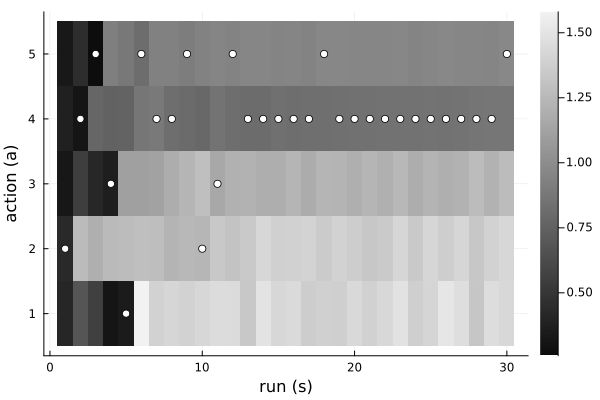

In [61]:
heatmap(hcat(Gs...), color=:grays, xlabel="run (s)", ylabel="action (a)")
scatter!(as, color=:white, label=false)